In [5]:
import os
import glob
import numpy as np
import pandas as pd
import copy
import mne
from fooof import FOOOF, FOOOFGroup
import re

In [2]:
file = '/Volumes/Nexus/Users/zouj/sEEG_data/spectra/sub-EM1029_ses-EMU_task-resting_run-01-spectrum.h5'
spectra = mne.time_frequency.read_spectrum(file)

/var/folders/3b/c572vxrx1rddt5284f3d5zh80000gn/T/ipykernel_61648/4181544048.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectra.pick([ 'LCM3', 'LCM4', 'LCM5']).plot()
/Users/jasminezou/Projects/mne-python/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


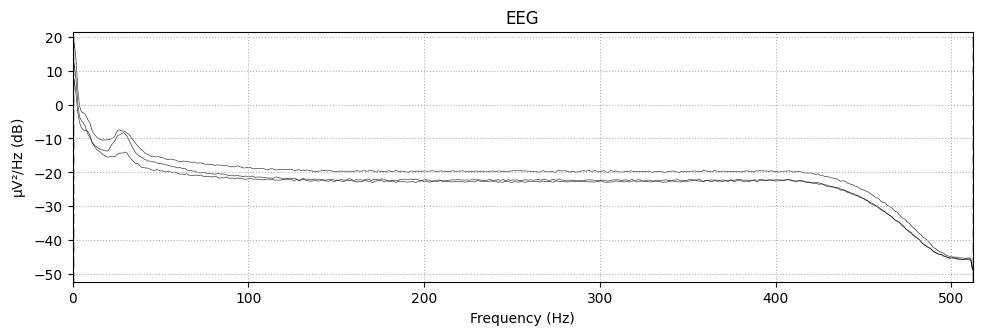

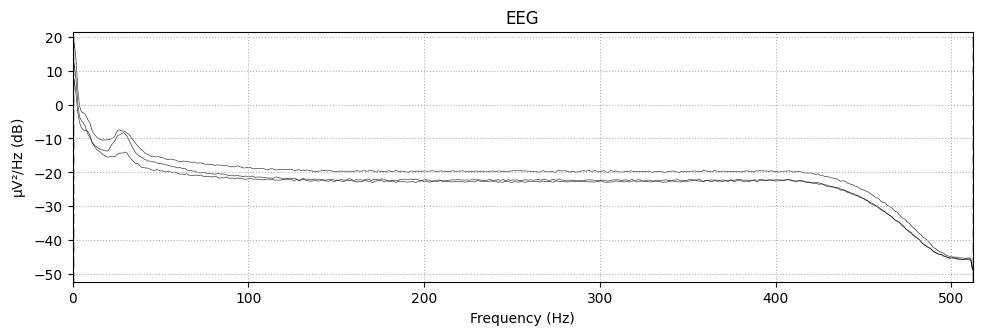

In [3]:
spectra.pick([ 'LCM3', 'LCM4', 'LCM5']).plot()

In [4]:
fg = FOOOFGroup(peak_width_limits=[2,50],
                  max_n_peaks = 6,
                  min_peak_height = 0.15,
                  peak_threshold = 2,
                  bw_std_edge = 1, 
                  aperiodic_mode = 'fixed',
                  #regularization_weight = 10**4
                  )
    
fg.fit(spectra.freqs, spectra.get_data(), freq_range = [1, 150])

Running FOOOFGroup across 3 power spectra.
-----
[[  1.           1.17912618   1.6986436 ]
 [ 29.           0.44476877   4.246609  ]
 [146.           0.17462487  22.08236681]
 [  7.           0.16731518   1.6986436 ]] [ 1.6986436   4.246609   22.08236681  1.6986436 ]
[False  True False  True]
[[29.          0.44476877  4.246609  ]
 [ 7.          0.16731518  1.6986436 ]]
guess for fitter [[ 7.          0.16731518  1.6986436 ]
 [29.          0.44476877  4.246609  ]]
guess given to fitter [[ 7.          0.16731518  1.6986436 ]
 [29.          0.44476877  4.246609  ]]
guess given right before flattening for fitting [[ 7.          0.16731518  1.6986436 ]
 [29.          0.44476877  4.246609  ]] ((1.9040691982718858, 0, 1.0, 16.260172995679714, 0, 1.0), (12.095930801728114, inf, 25.0, 41.73982700432029, inf, 25.0))
params post fitting [ 1.9040692   1.17526976  1.03690246 29.74477128  0.47882649  4.2855306 ]
gaussian_params pre sorting [[ 1.9040692   1.17526976  1.03690246]
 [29.74477128  0.478

In [5]:
fg.get_fooof(2).report()

-----
[[  1.           1.2553739    1.6986436 ]
 [  7.           0.34173824   2.5479654 ]
 [ 30.           0.27257945   3.3972872 ]
 [150.           0.22472101  25.        ]] [ 1.6986436  2.5479654  3.3972872 25.       ]
[False  True  True False]
[[ 7.          0.34173824  2.5479654 ]
 [30.          0.27257945  3.3972872 ]]
guess for fitter [[ 7.          0.34173824  2.5479654 ]
 [30.          0.27257945  3.3972872 ]]
guess given to fitter [[ 7.          0.34173824  2.5479654 ]
 [30.          0.27257945  3.3972872 ]]
guess given right before flattening for fitting [[ 7.          0.34173824  2.5479654 ]
 [30.          0.27257945  3.3972872 ]]
params post fitting [ 1.          1.09041074  2.53928069 29.66323118  0.26393204  2.92179091]
gaussian_params pre sorting [[ 1.          1.09041074  2.53928069]
 [29.66323118  0.26393204  2.92179091]]
gaussian_params [[ 1.          1.09041074  2.53928069]
 [29.66323118  0.26393204  2.92179091]]
                                                      

/Users/jasminezou/Projects/fooof/fooof/plts/style.py:172: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/jasminezou/Projects/fooof/fooof/plts/style.py:172: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/jasminezou/Projects/fooof/fooof/plts/style.py:172: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


# Data Wrangling

In [8]:
df_localization = pd.read_csv('/Volumes/Nexus/Users/zouj/sEEG_data/electrode-localizations.tsv', delimiter='\t')\
    [['Subject', 'label', 'electrode', 'is_thalamic', 'is_cortical']]
spectra_file_names = glob.glob('/Volumes/Nexus/Users/zouj/sEEG_data/spectra/*')
ch_dict = {}
for spectra_file in spectra_file_names:
    subject_pattern = r'EM\d{4}'
    subject = re.findall(subject_pattern, os.path.basename(spectra_file))[0]
    if subject not in ch_dict:
        spectra = mne.time_frequency.read_spectrum(spectra_file)
        ch_dict[subject] = spectra.ch_names
file_basenames = [os.path.basename(file_path) 
                  for file_path in glob.glob('/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof*100*/fits/*')]
dir_list = ['/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof_1-100hz_r4_bw1/fits',
            '/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof_1-150hz_r4_bw1/fits',
            '/Volumes/Nexus/Users/zouj/sEEG_data/fooof_outputs/fooof_1-200hz_r4_bw1/fits']
results_df_list = []

In [36]:
len(fg)

18

In [56]:
subject_list = []
ch_list = []
dir_list = []
for dir in dir_list:
    dir_name = os.path.basename(os.path.dirname(dir))
    for file in file_basenames:
        subject_pattern = r'EM\d{4}'
        subject = re.findall(subject_pattern, file)[0]

        run_pattern = r'run-\d[^a-zA-Z]*'
        run = re.findall(run_pattern, file)[0][:-1]

        fg = FOOOFGroup()
        fg.load(file, dir)

        for i in range(len(fg)):
            fooof = fg[i]#.get_fooof(i)
            gauss_params = fooof.gaussian_params
            CF, PW, BW = gauss_params[:, 0], gauss_params[:, 1], gauss_params[:, 2]
            if not np.all(CF - 1 > BW):
                print(subject, ch_dict[subject][i])
                subject_list.append(subject)
                ch_list.append(ch_dict[subject][i])
                dir_list.append(dir_name)

In [60]:
a = pd.DataFrame(np.array([dir_list, subject_list, ch_list]).T, columns = ['dir', 'Subject', 'ch'])

In [59]:
a.to_csv('/Users/jasminezou/Documents/test.csv')

In [ ]:
print()

In [32]:
for fooof in fg.group_results:
    gauss_params = fooof.gaussian_params
    CF, PW, BW = gauss_params[:, 0], gauss_params[:, 1], gauss_params[:, 2]
    print(CF - 1 >BW)

[ True]
[ True]
[ True]
[ True  True]
[ True  True]
[ True  True  True]
[ True  True]
[ True  True]
[ True  True  True]
[ True]
[ True  True  True]
[ True  True  True  True]
[ True  True  True]
[ True]
[ True  True  True]
[ True]
[ True  True  True]
[ True  True  True  True  True  True]


In [35]:
if not np.all([True, False]):
    print('hit')

hit


In [24]:
df = pd.DataFrame(np.row_stack([fooof.gaussian_params for fooof in fg.group_results])), 
                  columns=['CF', 'PW', 'BW'])
np.row_stack([fooof.gaussian_params for fooof in fg.group_results])

array([[1.62473914e+01, 3.29008982e-01, 3.51301291e+00],
       [1.75913570e+01, 3.44496721e-01, 4.02901252e+00],
       [1.66249270e+01, 4.28567378e-01, 3.40144796e+00],
       [1.49353505e+01, 3.84237474e-01, 2.11263303e+00],
       [2.07588846e+01, 2.65666150e-01, 3.69493636e+00],
       [1.52116669e+01, 3.70676161e-01, 2.10162506e+00],
       [2.06898854e+01, 2.72903817e-01, 3.76297321e+00],
       [1.52644729e+01, 4.05127086e-01, 1.94593588e+00],
       [2.10072269e+01, 2.95431998e-01, 2.92091695e+00],
       [2.56134957e+01, 1.07949908e-01, 1.00000000e+00],
       [1.45666834e+01, 4.60541744e-01, 1.80330371e+00],
       [1.81153507e+01, 1.77690437e-01, 2.76945604e+00],
       [1.53037479e+01, 3.89811451e-01, 2.15074369e+00],
       [2.11849694e+01, 2.34879557e-01, 4.47091355e+00],
       [1.85951354e+01, 3.88480018e-01, 4.48870092e+00],
       [2.40413952e+01, 2.44720379e-02, 4.65124266e+00],
       [3.98925329e+01, 1.35093789e-01, 8.81396982e+00],
       [2.15339350e+01, 7.26142

In [31]:
fooof.gaussian_params[:, 0]

array([ 4.78984966, 17.15184352, 28.22648723, 64.59362497, 76.46666079,
       92.10750368])

In [28]:
for fooof in fg.group_results:
    print(fooof.gaussian_params)
    print()



[[16.24739145  0.32900898  3.51301291]]
[[17.59135698  0.34449672  4.02901252]]
[[16.62492698  0.42856738  3.40144796]]
[[14.93535052  0.38423747  2.11263303]
 [20.75888464  0.26566615  3.69493636]]
[[15.21166695  0.37067616  2.10162506]
 [20.68988536  0.27290382  3.76297321]]
[[15.26447289  0.40512709  1.94593588]
 [21.00722688  0.295432    2.92091695]
 [25.61349574  0.10794991  1.        ]]
[[14.56668344  0.46054174  1.80330371]
 [18.1153507   0.17769044  2.76945604]]
[[15.30374792  0.38981145  2.15074369]
 [21.1849694   0.23487956  4.47091355]]
[[1.85951354e+01 3.88480018e-01 4.48870092e+00]
 [2.40413952e+01 2.44720379e-02 4.65124266e+00]
 [3.98925329e+01 1.35093789e-01 8.81396982e+00]]
[[21.53393502  0.07261429 12.87029109]]
[[12.9642179   0.14016232  1.32996386]
 [17.63455147  0.2291039   2.30844944]
 [28.13076828  0.15196411  3.8692964 ]]
[[ 4.23259494  0.1981745   1.        ]
 [14.90807445  0.2453972   3.90800424]
 [81.4565041   0.          2.12778948]
 [88.43788362  0.12864662 

In [20]:
pd.DataFrame(np.array([fooof.gaussian_params for fooof in fg.group_results]), 
                  columns=['CF', 'PW', 'BW'])


array([[16.24739145,  0.32900898,  3.51301291]])

In [15]:
fg.peak_params_

array([[15.22498049,  0.42487782,  3.16101297],
       [20.09008277,  0.35031633,  6.50175672],
       [23.85838614,  0.24900012,  9.5723526 ]])

In [16]:
fg.gaussian_params_

array([[15.22498049,  0.33030606,  1.58050649],
       [20.09008277,  0.25716593,  3.25087836],
       [23.85838614,  0.12428768,  4.7861763 ]])

In [ ]:
df_results_all = pd.concat(results_df_list, ignore_index=True)
df_results_all.insert(1, 'freq_range', [params.split('_')[1] for params in df_results_all['fitting_params']])
df_results_median = df_results_all.drop(['fitting_params','run'], axis=1).\
        groupby(['freq_range', 'Subject', 'label']).\
        median( ).\
        reset_index()
df_results_median_pivot = df_results_median.pivot(index=['Subject', 'label'], 
                        columns='freq_range')